In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


### Plot the number of ratings per movie and user

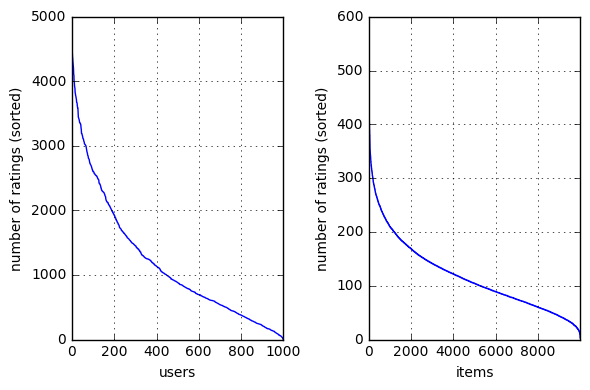

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
from helpers import split_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=1, p_test=0.1)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065327
Total number of nonzero elements in test data:111625


In [5]:
# temporary, just to create data subsets for tests
ratings_c = ratings.copy()
train_c = train.copy()
test_c = test.copy()
print(train.shape)
print(test.shape)
train_ = train[:100,:100]
test_ = test[:100,:100]

(10000, 1000)
(10000, 1000)


### Similarity

#### Compute the cost by the method of matrix factorization

In [8]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    sum_err = 0
    for d, n in nz:
        err = data[d,n] - np.dot(item_features[d,:],user_features[:,n])
        sum_err += err**2
    rmse = 0.5*sum_err/len(nz)
    return rmse

In [20]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(ratings_c, k = 40)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)


In [21]:
from helpers import calculate_error
print(calculate_error(ratings_c, X_pred))

3.76933971615


In [22]:
s

array([  212.62485678,   213.80651491,   214.80859219,   215.6192653 ,
         215.79199532,   216.02547978,   216.70004059,   217.01331797,
         218.13013801,   219.06214044,   219.65439793,   220.01621118,
         221.18057748,   222.50829938,   223.44410888,   224.49630283,
         224.95164313,   225.83004881,   226.69020294,   227.60152074,
         228.1182804 ,   229.99786331,   232.71860683,   233.66607985,
         233.73655199,   237.23087315,   238.20485496,   240.01783419,
         241.25251206,   243.77824705,   247.60657399,   255.30328865,
         260.40638048,   280.00034886,   290.2002441 ,   308.80015619,
         339.05363577,   413.38199288,   470.35630418,  2154.85038085])

In [23]:
s_diag_matrix

array([[  212.62485678,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,   213.80651491,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,   214.80859219, ...,
            0.        ,     0.        ,     0.        ],
       ..., 
       [    0.        ,     0.        ,     0.        , ...,
          413.38199288,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,   470.35630418,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,  2154.85038085]])

In [14]:
s

array([ 15.10501419,  16.13189912,  16.68253332,  17.02307687,
        17.77975668,  18.1193198 ,  18.90896771,  19.01936633,
        19.54303725,  20.28904086,  20.83221178,  21.74599442,
        22.66199777,  22.94756382,  23.58918447,  24.70571621,
        25.60689575,  25.98036212,  26.52300793,  61.57090447])

In [11]:
vt.shape

(20, 100)

In [12]:
s_diag_matrix=np.diag(s)

In [13]:
s_diag_matrix

array([[ 15.10501419,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  16.13189912,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  16.68253332,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  

In [ ]:
from helpers import calculate_mse
print(calculate_mse(ratings,pred))

In [60]:
from helpers import calculate_mse

def matrix_factorization_SGD(train, test, K_feat, epochs):
    """matrix factorization by SGD."""
    # define parameters
    num_features = K_feat   # K in the lecture notes
    
    num_epochs = epochs     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    #user_features = saved_user_features.copy()
    #item_features = saved_item_features.copy()
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        for d, n in nz_train: # iterate over non zero elements
        
        
        
        rmse_train = compute_error(train, user_features, item_features, nz_train) # for each epoch, last rmse_train value is returned
        errors.append(rmse_train)

    print("iter: {}, RMSE on training set: {}.".format(it, rmse_train))
    # evaluate the test error
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    rmse_test = compute_error(test, user_features, item_features, nz_train) 
    print("RMSE on test data: {}.".format(rmse_test))
    return user_features, item_features, rmse_train, rmse_test

user_features, item_features, rmse_train, rmse_test = matrix_factorization_SGD(train_c, test_c,20,10)

learn the matrix factorization using SGD...
iter: 9, RMSE on training set: 0.45788968731115065.
RMSE on test data: 7.587707006620173.


In [61]:
# save matrices W and Z after 20 iterations
saved_user_features = user_features.copy()
saved_item_features = item_features.copy()

#### Create prediction matrix

In [62]:
# assign predicted values to prediction matrix
def create_prediction_matrix(prediction):
    nz_row, nz_col = prediction.nonzero()
    nz_pred = list(zip(nz_row, nz_col))
    for d, n in nz_pred:
        pred = np.dot(saved_item_features[d,:],saved_user_features[:,n]) # matrices item_features and user_features are already computed above
        prediction[d,n] = round(pred)
    return prediction

pred = create_prediction_matrix(ratings_c.copy())
print(calculate_mse(ratings_c, pred)) # only when test data and not submission

0.1189789


### Make submission

In [39]:
# load test data
from helpers import load_data, preprocess_data

path_dataset = "data/sampleSubmission.csv"
prediction = load_data(path_dataset)

number of items: 10000, number of users: 1000


In [43]:
from helpers import create_csv_submission_proj2
# estimate prediction matrix using method of ...
#ratings_c = ratings.copy()
prediction = create_prediction_matrix(prediction)
    
# create submission
create_csv_submission_proj2(prediction, 'data/prediction_SGD_2.csv')